# JEE Rank Data Analysis and Modeling (2016-2024)
This notebook provides a detailed analysis of JEE rank data from 2016 to 2024, including data cleaning, exploratory data analysis (EDA), and building machine learning models for rank prediction.

## 1. Data Import and Setup
First, let's import the necessary libraries and load the dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
import kagglehub

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [2]:
breadnbu22er_or_cr_2016_to_2024_path = kagglehub.dataset_download('breadnbu22er/or-cr-2016-to-2024')# Change to your dataset path
file_path=f'{breadnbu22er_or_cr_2016_to_2024_path}/JEE_Rank_2016_2024.csv'
df = pd.read_csv(file_path)

100%|██████████| 229k/229k [00:00<00:00, 29.6MB/s]

Extracting files...



# Display the first few rows of the dataset

In [3]:
df.head()

,Institute,Quota,Gender,Year,Academic_Program_Name,Closing_Rank,Opening_Rank,Seat_Type
0,Indian Institute of Technology Bhubaneswar,AI,Gender-Neutral,2016,"Mechanical Engineering (4 Years, Bachelor of T...",651,583,ST
1,Indian Institute of Technology Bombay,AI,Gender-Neutral,2016,"Civil Engineering (4 Years, Bachelor of Techno...",21,21,OBC-NCL (PwD)
2,Indian Institute of Technology Bombay,AI,Gender-Neutral,2016,"Computer Science and Engineering (4 Years, Bac...",60,1,OPEN
3,Indian Institute of Technology Bombay,AI,Gender-Neutral,2016,Energy Engineering with M.Tech. in Energy Syst...,848,338,SC
4,Indian Institute of Technology Bombay,AI,Gender-Neutral,2016,Metallurgical Engineering and Materials Scienc...,2971,1657,OPEN


## 2. Data Cleaning and Preprocessing
We will start by checking for missing values, handling data types, and performing basic cleaning tasks.


In [4]:
# Check for missing values
df.isnull().sum()

# Convert 'Opening_Rank' and 'Closing_Rank' to numeric, coercing errors to NaN
df['Opening_Rank'] = pd.to_numeric(df['Opening_Rank'], errors='coerce')
df['Closing_Rank'] = pd.to_numeric(df['Closing_Rank'], errors='coerce')

# Drop rows with NaN values in 'Opening_Rank' or 'Closing_Rank'
df.dropna(subset=['Opening_Rank', 'Closing_Rank'], inplace=True)

# Verify data types
df.dtypes


,0
Institute,object
Quota,object
Gender,object
Year,int64
Academic_Program_Name,object
Closing_Rank,float64
Opening_Rank,float64
Seat_Type,object


## 3. Exploratory Data Analysis (EDA)
Let's begin by exploring the distribution of ranks and extracting key insights.


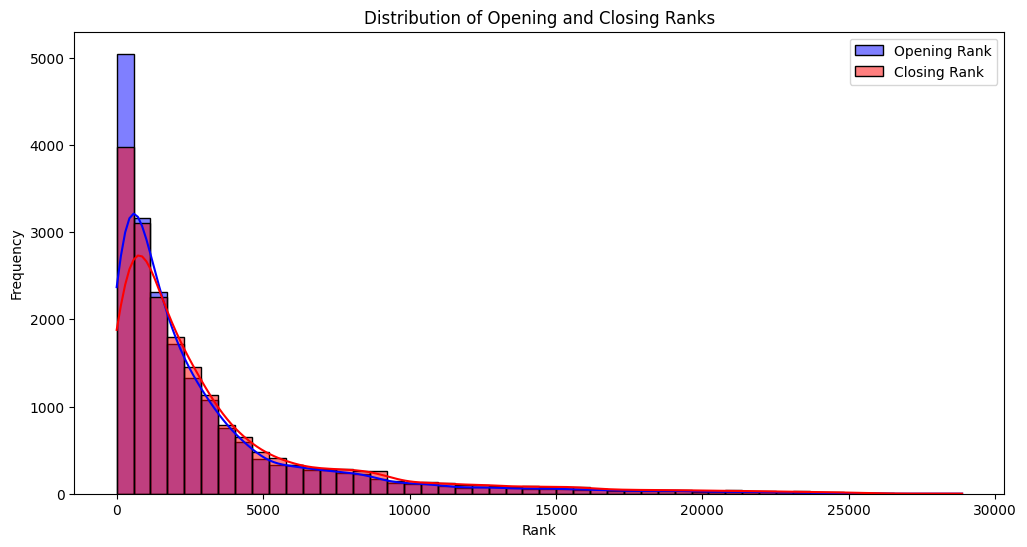

In [5]:
# Distribution of Opening and Closing Ranks
plt.figure(figsize=(12, 6))
sns.histplot(df['Opening_Rank'], bins=50, color='blue', label='Opening Rank', kde=True)
sns.histplot(df['Closing_Rank'], bins=50, color='red', label='Closing Rank', kde=True)
plt.title('Distribution of Opening and Closing Ranks')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()
plt.show()


**Deductions:**

Most of the ranks are concentrated in the lower range, indicating the popularity of top institutes and programs.


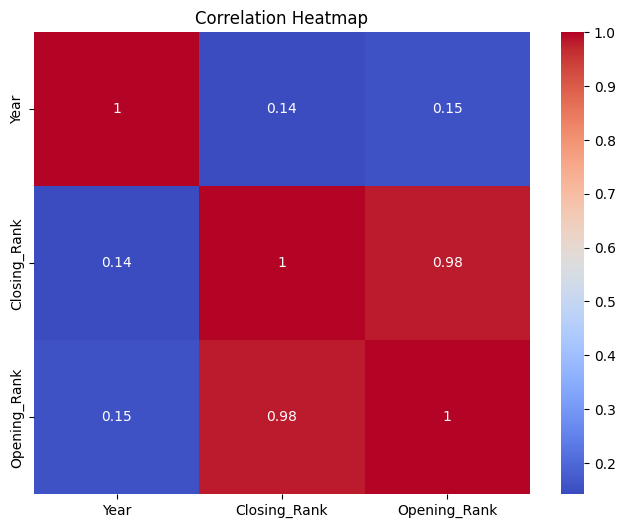

In [6]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**Deductions:**

A strong correlation exists between opening and closing ranks, indicating that top institutes tend to maintain consistent rank demand throughout the counseling process.

#Institute-wise Opening and Closing Rank Trends

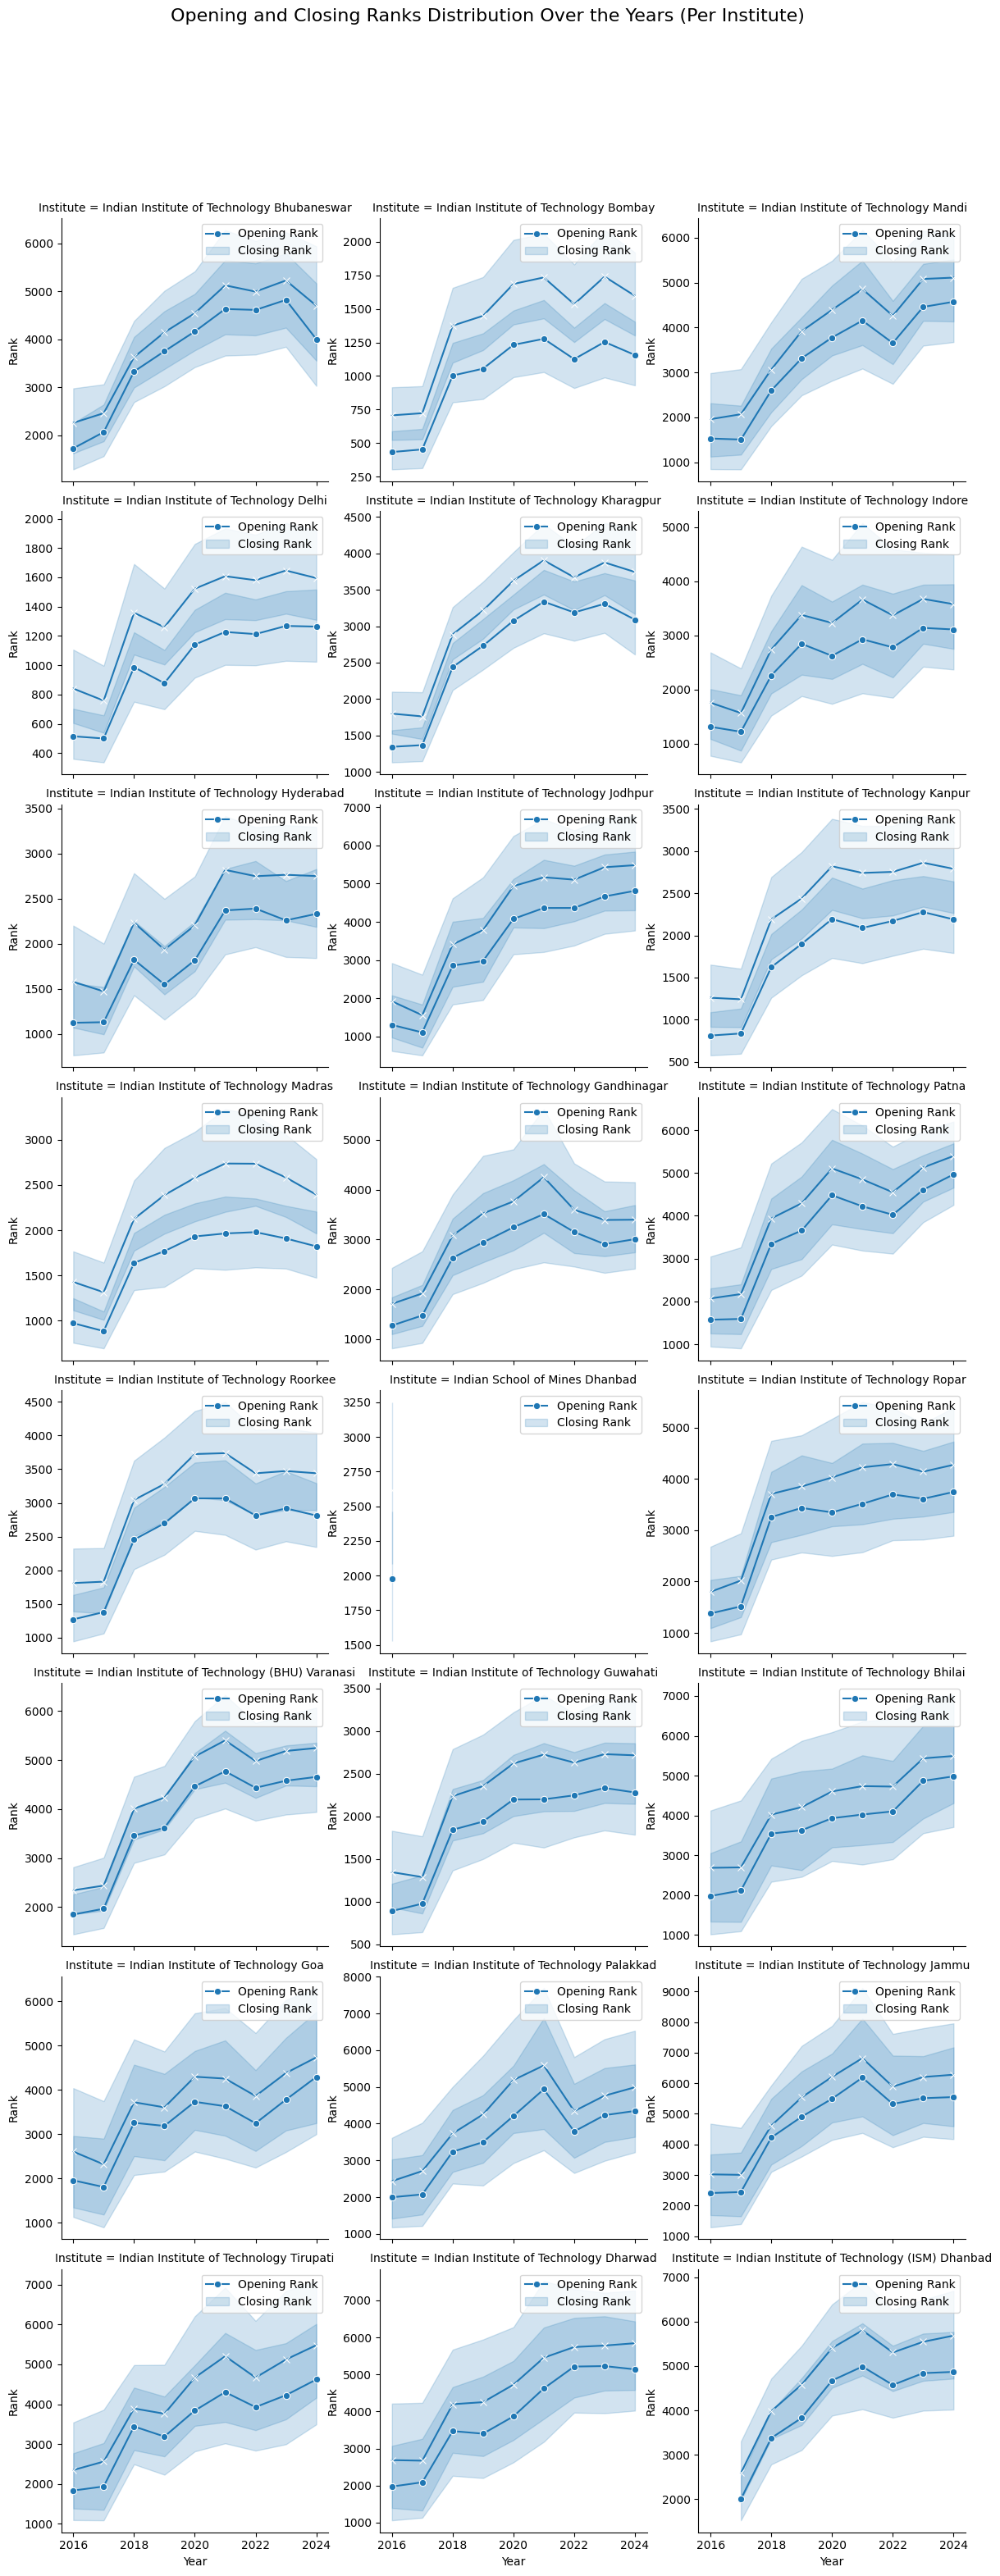

In [7]:
# Opening and Closing Rank Trends per Institute
g = sns.FacetGrid(df, col="Institute", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Year", y="Opening_Rank", marker='o', label='Opening Rank')
g.map_dataframe(sns.lineplot, x="Year", y="Closing_Rank", marker='x', label='Closing Rank')

for ax in g.axes.flat:
    ax.legend(['Opening Rank', 'Closing Rank'])
    ax.set_title(ax.get_title(), fontsize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Rank')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Opening and Closing Ranks Distribution Over the Years (Per Institute)', fontsize=16)
plt.show()


**Deductions:**

Some institutes have a consistent demand with minimal fluctuations in rank, while others show significant variation year by year.

# Gender-wise Closing Rank Distribution

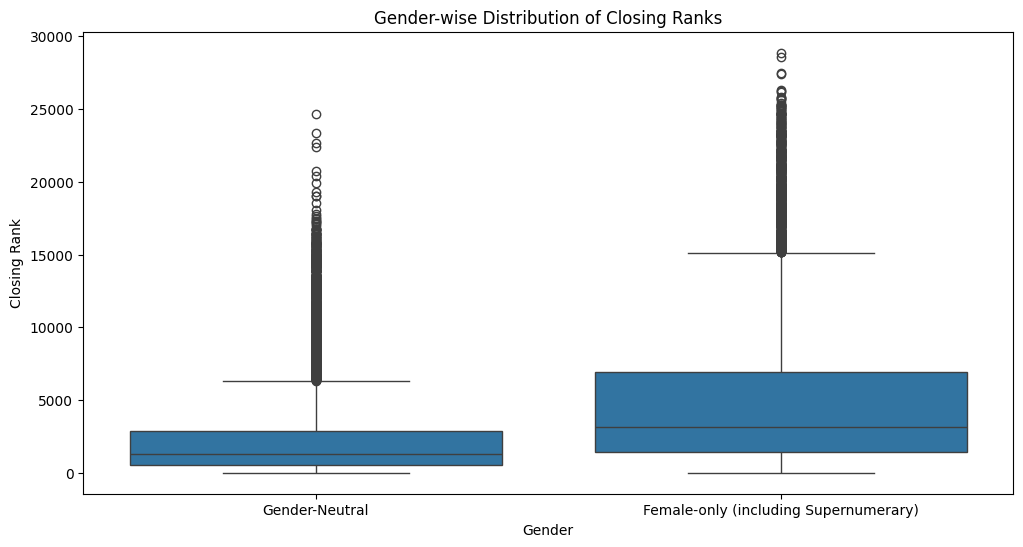

In [8]:
# Gender-wise Distribution of Closing Ranks
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gender', y='Closing_Rank', data=df)
plt.title('Gender-wise Distribution of Closing Ranks')
plt.xlabel('Gender')
plt.ylabel('Closing Rank')
plt.show()


**Deductions:**

There is some disparity in rank distribution across genders, with females generally having a higher closing rank.

# Top Academic Programs by Opening Rank

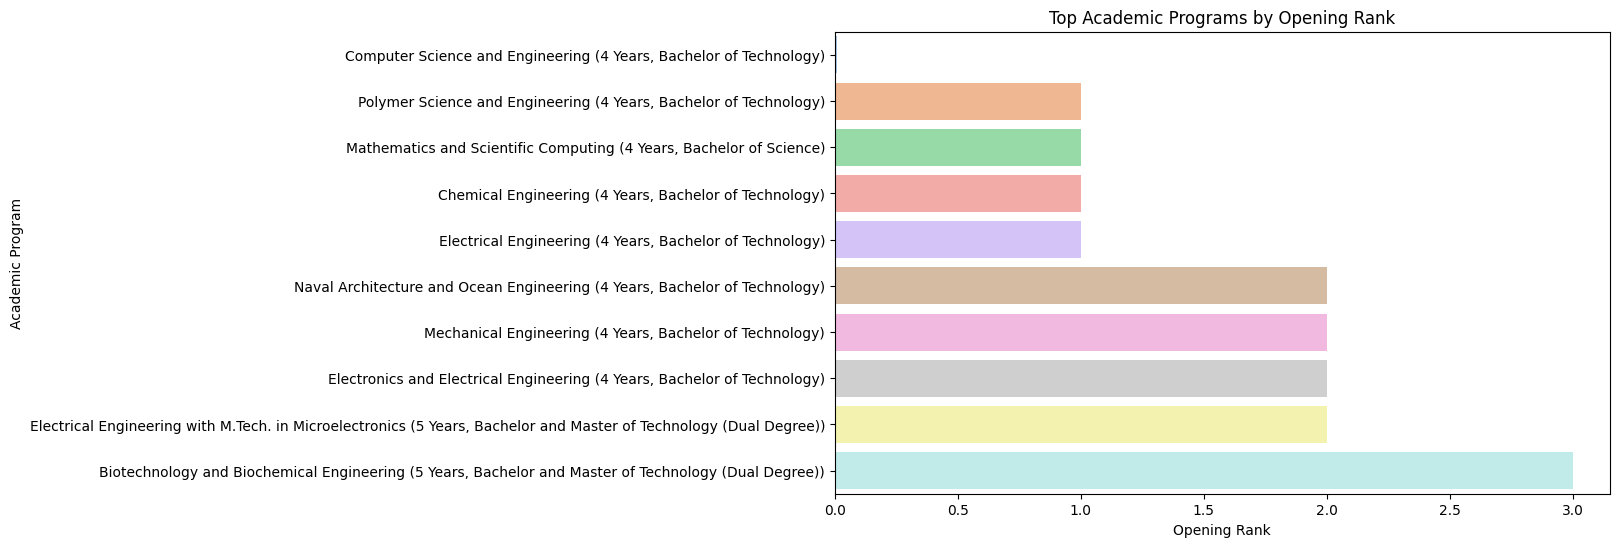

In [9]:
# Top Academic Programs by Opening Rank
top_programs = df.groupby('Academic_Program_Name')['Opening_Rank'].min().sort_values().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_programs.index, x=top_programs.values, palette='pastel')
plt.title('Top Academic Programs by Opening Rank')
plt.xlabel('Opening Rank')
plt.ylabel('Academic Program')
plt.show()


# Year-wise Rank Trends by Quota


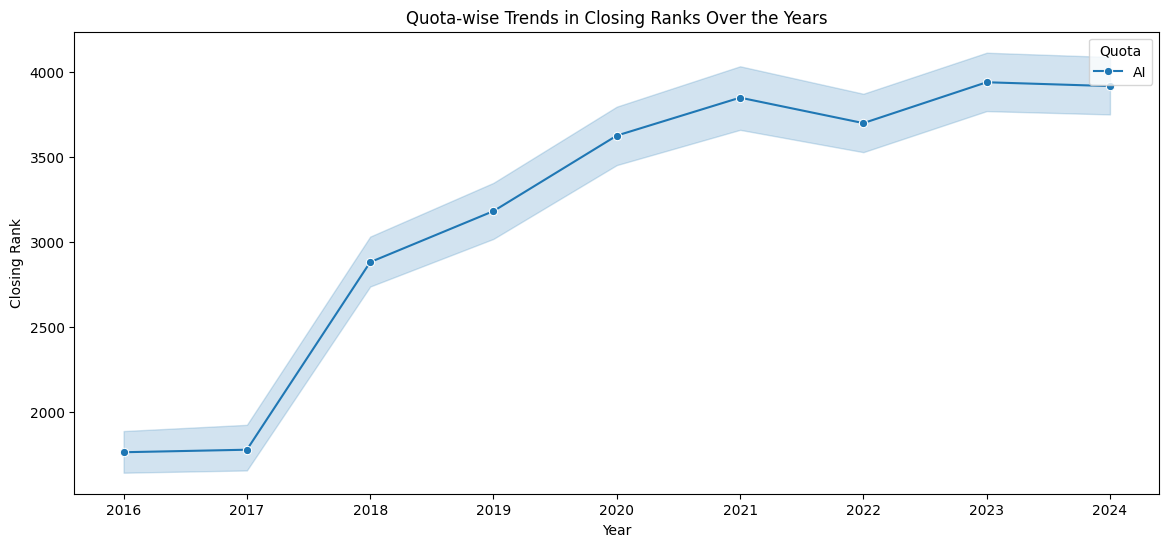

In [13]:
# Quota-wise Trends in Closing Ranks Over the Years
plt.figure(figsize=(14, 6))
sns.lineplot(x='Year', y='Closing_Rank', hue='Quota', data=df, marker='o')
plt.title('Quota-wise Trends in Closing Ranks Over the Years')
plt.xlabel('Year')
plt.ylabel('Closing Rank')
plt.legend(title='Quota')
plt.show()


**Deductions:**

The quota system impacts rank trends, with general category students often occupying the top ranks.

## 4. Predictive Modeling: Closing Rank Prediction
We will use a machine learning model (Random Forest) to predict the closing rank based on other features in the dataset.


In [14]:
# Prepare the data
X = df.drop(columns=['Closing_Rank'])
X = pd.get_dummies(X, drop_first=True)
y = df['Closing_Rank']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 280.86038198821416


## 5. Bonus: Predicting Popular Choices (Branch/Institute)
We'll build a classification model to predict whether a branch or institute is a "popular choice" (defined as having a closing rank within the top 1000).


In [12]:
# Convert branch/institute to a binary classification problem (popular or not)
df['Popular_Choice'] = np.where(df['Closing_Rank'] < 1000, 1, 0)  # Assuming top 1000 ranks indicate popularity

# Prepare data for classification
X = df.drop(columns=['Popular_Choice', 'Closing_Rank', 'Opening_Rank'])
X = pd.get_dummies(X, drop_first=True)
y = df['Popular_Choice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9561875480399693
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2634
           1       0.93      0.94      0.93      1269

    accuracy                           0.96      3903
   macro avg       0.95      0.95      0.95      3903
weighted avg       0.96      0.96      0.96      3903

